In [142]:
from gensim.models import word2vec
import seaborn as sns
import pylab as plt
import pandas as pd
import numpy as np
import pickle
from scipy import sparse
import gc
import sys
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [143]:
load_pickle = False


start_date_train = '2009-01-01'
date_test = '2014-10-01'
min_seq_length = 5
max_seq_length = 100


movies_min_ratings = 20


if load_pickle:
    with open("../data/Movielens/ml-20m/df_date.pickle", 'rb') as handle:
        df_date = pickle.load(handle)
else:
    #Ratings .dat format: UserID::MovieID::Rating::Timestamp
    user_ids = []
    movie_ids = []
    ratings = []
    timestamps = []
    dataset_file = "../data/Movielens/ml-20m/ratings.csv"
    df = pd.read_csv(dataset_file)
    df['userId'] = df['userId'].astype(np.int32)
    df['movieId'] = df['movieId'].astype(np.int32)
    df['rating'] = df['rating'].astype(np.float16)
    df['date'] = pd.to_datetime(df['timestamp'],unit='s')

    df_date = df[df.date > start_date_train]

# Filter out movies with less than X ratings
filter_movies = df_date.movieId.value_counts()[(df_date.movieId.value_counts() > movies_min_ratings)].index.values
df_date = df_date[df_date.movieId.isin(filter_movies)]
print('Total number of ratings:' + str(len(df_date)))
print('Number of different users: ' + str(len(df_date['userId'].unique())))
print('Number of different movies: ' + str(len(df_date['movieId'].unique())))
sys.stdout.flush()
# Filter out users with less than X ratings
filter_users = df_date['userId'].value_counts()[(df_date['userId'].value_counts() >= min_seq_length)].index.values
df_date = df_date[df_date.userId.isin(filter_users)]
print('Total number of ratings:' + str(len(df_date)))
print('Number of different users: ' + str(len(df_date['userId'].unique())))
print('Number of different movies: ' + str(len(df_date['movieId'].unique())))

# Build array mapping movie_id --> position in one-hot encoding
movieIds = np.zeros(max(df_date['movieId'].unique()) + 1, np.uint16)
i = 0
for movieId in df_date['movieId'].unique():
    movieIds[movieId] = i
    i += 1



seq_lengths = []
num_diff_items = len(df_date.movieId.unique())

grouped = df_date.groupby('userId')

movie_sequences = []
i = 0
for name, group in grouped:
    # sorting by ratings
    movie_sequences.append(group.sort_values(['rating', 'date']).movieId.values.astype(str).tolist())
    i += 1


Total number of ratings:4687202
Number of different users: 36395
Number of different movies: 10057
Total number of ratings:4685946
Number of different users: 35821
Number of different movies: 10057


In [144]:
model = gensim.models.Word2Vec.load("word2vec_64_window_10_iters_25_start_2009-01-01.bin")

2017-06-23 09:42:41,832 : INFO : loading Word2Vec object from word2vec_64_window_10_iters_25_start_2009-01-01.bin
2017-06-23 09:42:42,058 : INFO : loading wv recursively from word2vec_64_window_10_iters_25_start_2009-01-01.bin.wv.* with mmap=None
2017-06-23 09:42:42,059 : INFO : setting ignored attribute syn0norm to None
2017-06-23 09:42:42,062 : INFO : setting ignored attribute cum_table to None
2017-06-23 09:42:42,065 : INFO : loaded word2vec_64_window_10_iters_25_start_2009-01-01.bin


In [5]:
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
 
# train word2vec on the two sentences
embedding_size = 64
window_size = 10
iters = 25
model = gensim.models.Word2Vec(movie_sequences,  size=embedding_size, sg=1, window=window_size, min_count=1, iter=iters)
model.save("word2vec_" + str(embedding_size) + "_window_" + str(window_size) + "_iters_" + str(iters) + '_start_' + str(start_date_train) + ".bin")

2017-06-07 14:36:17,251 : INFO : collecting all words and their counts
2017-06-07 14:36:17,251 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-06-07 14:36:17,769 : INFO : PROGRESS: at sentence #10000, processed 1306399 words, keeping 10057 word types
2017-06-07 14:36:18,274 : INFO : PROGRESS: at sentence #20000, processed 2615188 words, keeping 10057 word types
2017-06-07 14:36:18,649 : INFO : PROGRESS: at sentence #30000, processed 3925079 words, keeping 10057 word types
2017-06-07 14:36:18,866 : INFO : collected 10057 word types from a corpus of 4685946 raw words and 35821 sentences
2017-06-07 14:36:18,867 : INFO : Loading a fresh vocabulary
2017-06-07 14:36:18,932 : INFO : min_count=1 retains 10057 unique words (100% of original 10057, drops 0)
2017-06-07 14:36:18,932 : INFO : min_count=1 leaves 4685946 word corpus (100% of original 4685946, drops 0)
2017-06-07 14:36:18,995 : INFO : deleting the raw counts dictionary of 10057 items
2017-06-07 14:36:18

In [38]:
# Save embedding matrix

W_emb = np.zeros((10057, embedding_size))
for movieId in df_date['movieId'].unique():
    W_emb[movieIds[movieId], :] = model[str(movieId)]
with open("pickles/movielens/W_emb_64.pickle", 'wb') as handle:
    pickle.dump(W_emb, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [145]:
dataset_file = "../data/Movielens/ml-20m/movies.csv"
df_movies = pd.read_csv(dataset_file)
print(len(df_movies.movieId.unique()))
df_movies = df_movies[df_movies.movieId.isin(df_date.movieId.unique())]
print(len(df_movies.movieId.unique()))

# Preprocess year
years = []
for movie_title in df_movies.title:
    year = movie_title[movie_title.find("(")+1:movie_title.find(")")]
    if not year.isdigit():
        year = 0
    years.append(int(year))
df_movies['year'] = years

27278
10057


In [146]:
# Find specific movie
df_movies[df_movies['title'].str.contains("Lord of the Rings")]
# Find movie by genre
# df_movies[df_movies['genres'].str.contains("Musical")]

,movieId,title,genres,year
2032,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy,1978
4897,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,2001
5853,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,2002
7041,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,2003


In [147]:
id_movie = 260
print('Movie: ' + str(df_movies[df_movies.movieId == id_movie]))
similars = model.similar_by_word(str(id_movie), topn=25, restrict_vocab=None)
movies = []
genres = []
similarities = []
ids = []
for sim in similars:
    #ids_sim.append(int(sim[0]))
    movie = df_movies[df_movies.movieId == int(sim[0])]
    ids.append(movie.movieId.values[0])
    movies.append(movie.title.values[0])
    genres.append(movie.genres.values[0])
    similarities.append(float(sim[1]))
df_similars = pd.DataFrame()
df_similars['ids'] = ids
df_similars['movies'] = movies
df_similars['genres'] = genres
df_similars['similarities'] = similarities
df_similars

2017-06-23 09:42:42,503 : INFO : precomputing L2-norms of word weight vectors


Movie:      movieId                                      title  \
257      260  Star Wars: Episode IV - A New Hope (1977)   

                      genres  year  
257  Action|Adventure|Sci-Fi  1977  


,ids,movies,genres,similarities
0,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,0.983758
1,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,0.920903
2,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,0.899631
3,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.864530
4,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,0.782827
5,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,0.768775
6,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0.753819
7,318,"Shawshank Redemption, The (1994)",Crime|Drama,0.744610
8,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,0.739141
9,527,Schindler's List (1993),Drama|War,0.736843


In [148]:
# Train T-SNE with all the data
from sklearn.manifold import TSNE

data_tsne = []
dict_movieId_pos = {}
i = 0
for word in model.wv.vocab:
    vector = model[word]
    data_tsne.append(vector)
    dict_movieId_pos[word] = i
    i += 1
    
data_tsne = np.array(data_tsne)
print(data_tsne.shape)
model_tsn_all = TSNE(n_components=2, random_state=17)
Y_tsn_all = model_tsn_all.fit_transform(data_tsne)

# Create data frame
df_tsne = pd.concat([pd.DataFrame(Y_tsn_all),
                pd.Series(list(model.wv.vocab))],
               axis=1)

df_tsne.columns = ['x', 'y', 'movie_id']

titles = []
genres = []
years = []
for movie_id in df_tsne.movie_id:
    titles.append(df_movies[df_movies.movieId == int(movie_id)].title.values[0])
    genres.append(df_movies[df_movies.movieId == int(movie_id)].genres.values[0])
    years.append(df_movies[df_movies.movieId == int(movie_id)].year.values[0])
df_tsne['title'] = titles
df_tsne['genres'] = genres
df_tsne['years'] = years

(10057, 64)


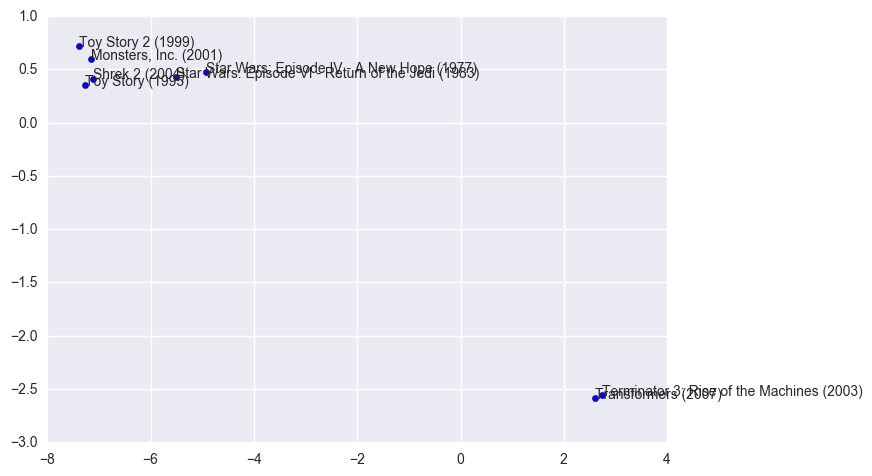

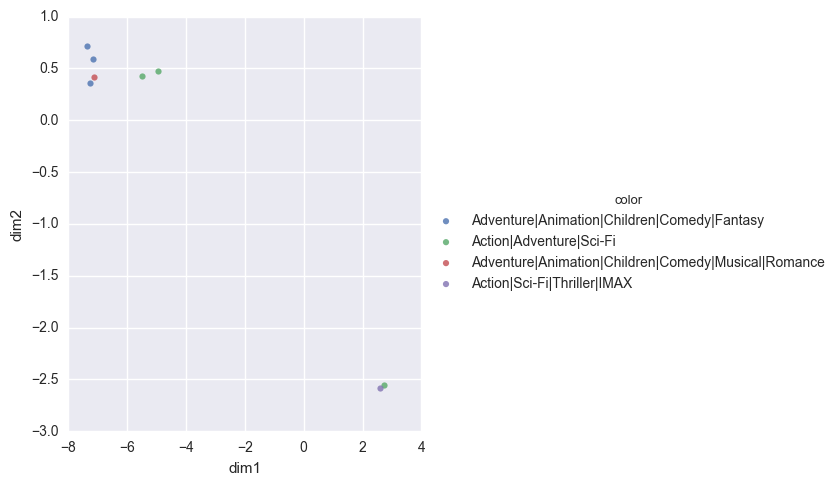

In [149]:
# Visualize n random examples with tsne with annotations
df_show = df_tsne.sample(n=10)

# Visualize specific movies 1(Toy Story), 595(Beautry and Beast), 588(Aladin), 1240(Terminator), 2985(Robocop),  
ids = [4886, 1, 3114, 8360, 260, 1210, 53996, 6537]
ids = [str(i) for i in ids]
df_show = df_tsne[df_tsne.movie_id.isin(ids)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_show['x'], df_show['y'])

for i, txt in enumerate(df_show['title']):
    ax.annotate(txt, (df_show['x'].iloc[i], df_show['y'].iloc[i]), fontsize=10)
fig.savefig('scatter_annotations.png')
plt.show()

df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genres']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.show()

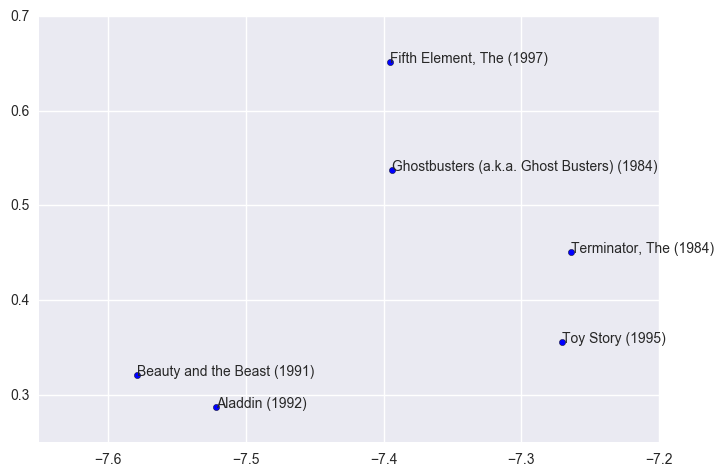

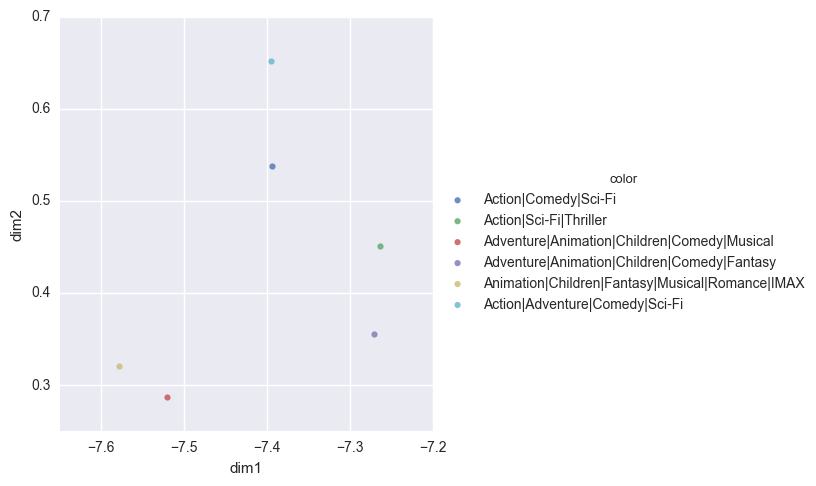

In [150]:
# Visualize n random examples with tsne with annotations
df_show = df_tsne.sample(n=10)

# Visualize specific movies 1(Toy Story), 595(Beautry and Beast), 588(Aladin), 1240(Terminator), 2985(Robocop),  
ids = [1, 595, 588, 1240, 2716, 1527]
ids = [str(i) for i in ids]
df_show = df_tsne[df_tsne.movie_id.isin(ids)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_show['x'], df_show['y'])

for i, txt in enumerate(df_show['title']):
    ax.annotate(txt, (df_show['x'].iloc[i], df_show['y'].iloc[i]), fontsize=10)
fig.savefig('scatter_annotations.png')
plt.show()

df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genres']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.show()

# Plot per year

In [14]:
df_tsne['year_category'] = 'Null'
df_tsne.loc[(df_tsne.years > 1900) & (df_tsne.years < 1970),'year_category'] = 'Old (1900-1970)'
#df_tsne.loc[(df_tsne.years > 1950) & (df_tsne.years < 2000),'year_category'] = '1950-1990'
df_tsne.loc[(df_tsne.years > 2000),'year_category'] = 'New (2000 or newer)'



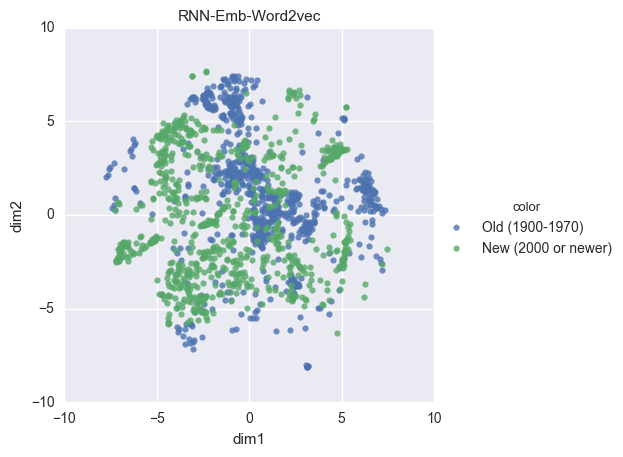

In [46]:
# Using the tsne with all the data
n_samples = 800
df_show1 = df_tsne[df_tsne.year_category == 'Old (1900-1970)'].sample(n=n_samples)
#df_show2 = df_tsne[df_tsne.year_category == '1950-1990'].sample(n=n_samples)
df_show3 = df_tsne[df_tsne.year_category == 'New (2000 or newer)'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show3])

#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)

#ax.scatter(df_show['x'], df_show['y'])

#for i, txt in enumerate(df_show['year_category']):
    #ax.annotate(txt, (df_show['x'].iloc[i], df_show['y'].iloc[i]))
#fig.savefig('scatter_annotations.png')
#plt.show()

df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['year_category']))
#plt.figure(figsize=(3, 2))
g = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False, size=4.60, aspect=1.035)
#g = (g.set(xlim=(-8, 8), ylim=(-8, 8), xticks=[-6, -4, -2, 0, 2, 4, 6], yticks=[-6, -4, -2, 0, 2, 4, 6]))
plt.title('RNN-Emb-Word2vec', fontsize=11)
plt.show()

# Plot per year (more categories)

In [47]:
df_tsne['year_category_2'] = 'Null'
df_tsne.loc[(df_tsne.years >= 1900) & (df_tsne.years < 2008),'year_category_2'] = 'before 2010'
df_tsne.loc[(df_tsne.years >= 2010) & (df_tsne.years < 2013),'year_category_2'] = '2010 - 2013'
df_tsne.loc[(df_tsne.years >= 2013) & (df_tsne.years < 2014),'year_category_2'] = '2013 - 2014'
df_tsne.loc[(df_tsne.years >= 2014),'year_category_2'] = '2014 or newer'

#df_pca['year_category_2'] = 'Null'
#df_pca.loc[(df_pca.years >= 1900) & (df_pca.years < 2008),'year_category_2'] = 'before 2010'
#df_pca.loc[(df_pca.years >= 2010) & (df_pca.years < 2013),'year_category_2'] = '2010 - 2013'
#df_pca.loc[(df_pca.years >= 2013) & (df_pca.years < 2014),'year_category_2'] = '2013 - 2014'
#df_pca.loc[(df_pca.years >= 2014),'year_category_2'] = '2014 or newer'

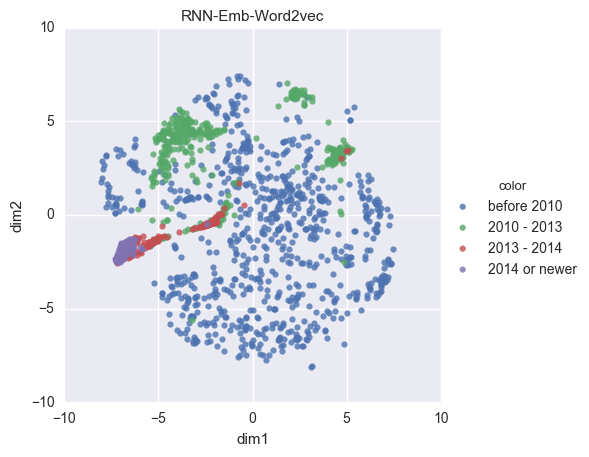

In [48]:

n_samples = 400
df_show1 = df_tsne[df_tsne.year_category_2 == 'before 2010'].sample(n=800)
df_show2 = df_tsne[df_tsne.year_category_2 == '2010 - 2013'].sample(n=n_samples)
df_show3 = df_tsne[df_tsne.year_category_2 == '2013 - 2014'].sample(n=200)
df_show4 = df_tsne[df_tsne.year_category_2 == '2014 or newer'].sample(n=150)
df_show = pd.concat([df_show1, df_show2, df_show3, df_show4])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['year_category_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False, size=4.60, aspect=1.035)
plt.title('RNN-Emb-Word2vec', fontsize=11)
plt.show()

# Plot per genres

In [138]:
romance_genres = ['Comedy|Romance', 'Comedy|Musical|Romance', 'Musical|Romance', 'Fantasy|Musical|Romance', 'Romance', 'Comedy|Romance|Thriller',
                'Fantasy|Romance', 'Drama|Romance']
#romance_genres = ['Sci-Fi', 'Action|Sci-Fi']
children_genres = ['Animation|Children|Fantasy', 'Action|Animation|Children|Comedy', 'Adventure|Animation|Children|Fantasy',
                  'Animation|Children', 'Adventure|Children|Fantasy', 'Action|Animation|Children', 'Adventure|Children',
                  'Adventure|Animation|Children', 'Children|Comedy|Fantasy', 'Children|Fantasy', 'Action|Children',
                  'Action|Children|Fantasy', 'Children', 'Animation|Children|Fantasy|IMAX', 'Action|Adventure|Children|IMAX',
                  'Adventure|Children|Comedy|Fantasy|Mystery', 'Adventure|Children|Drama|Fantasy', 'Animation|Children|Fantasy|IMAX',
                  'Children|Comedy']
horror_genres = ['Horror|Mystery|Thriller', 'Horror', 'Horror|Thriller', 'Action|Horror', 'Drama|Horror|Thriller'
                'Drama|Horror', 'Crime|Horror|Thriller', 'Action|Crime|Horror', 'Crime|Horror', 'Crime|Horror|Mystery'
                'Crime|Drama|Horror']

action_genres = ['Action|Crime', 'Action|Drama', 'Action|Adventure', 'Action|Crime|Thriller']

In [134]:
for gen in df_tsne.genres:
    if 'Action' in gen:
        print(gen)

Action|Adventure|Fantasy
Action|Crime|Thriller
Action|Drama
Action|Adventure|Drama
Action|Drama|Thriller|War
Action|Adventure|Drama|Thriller|Western
Action|Crime|Drama|Thriller
Action|Sci-Fi|Thriller
Action|Crime|Drama|Thriller
Action|Adventure|Thriller|IMAX
Action|Drama|Thriller|War
Action|Crime|Drama|Thriller
Action|Adventure|Drama|Mystery|Thriller
Action|Adventure|War
Action|Comedy|Crime
Action|Sci-Fi|Thriller
Action|Crime
Action|Adventure
Action|Sci-Fi|Thriller
Action|Crime|Drama
Action|Drama|War
Action|Drama|Thriller
Action|Adventure|Comedy|Crime|Thriller
Action|Adventure|Drama|War
Action|Adventure|Thriller
Action|Horror|Sci-Fi|IMAX
Action|Horror
Action|Horror|Sci-Fi|Thriller
Action|Crime|Thriller
Action|Drama
Action|Crime|Thriller
Action|Comedy|Sci-Fi
Action|Sci-Fi
Action|Comedy|Crime|Thriller
Action|Drama|Sci-Fi|IMAX
Action|Animation|Comedy|Sci-Fi|Western
Action|Romance
Action|Adventure|Comedy
Action|Adventure
Action|Comedy|Crime
Action|Horror|Sci-Fi|Thriller
Action|Fantasy|Horr

In [139]:
df_tsne['genre_1'] = 'Null'
df_tsne.loc[df_tsne.genres.isin(romance_genres), 'genre_1'] = 'Romance'
df_tsne.loc[df_tsne.genres.isin(children_genres), 'genre_1'] = 'Children'
df_tsne.loc[df_tsne.genres.isin(horror_genres), 'genre_1'] = 'Horror'
df_tsne.loc[df_tsne.genres.isin(action_genres), 'genre_1'] = 'Action'



In [140]:
print(len(df_tsne[df_tsne.genre_1 == 'Romance']))
print(len(df_tsne[df_tsne.genre_1 == 'Children']))
print(len(df_tsne[df_tsne.genre_1 == 'Horror']))
print(len(df_tsne[df_tsne.genre_1 == 'Action']))

820
212
415
200


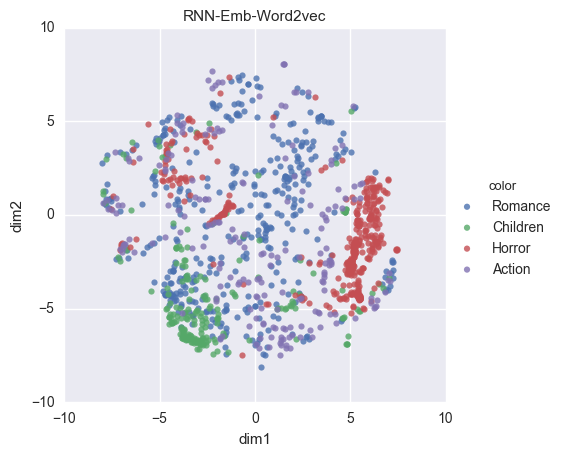

In [141]:
# Using the tsne with all the data
n_samples = 200
df_show1 = df_tsne[df_tsne.genre_1 == 'Romance'].sample(n=400)
df_show2 = df_tsne[df_tsne.genre_1 == 'Children'].sample(n=212)
df_show3 = df_tsne[df_tsne.genre_1 == 'Horror'].sample(n=400)
df_show4 = df_tsne[df_tsne.genre_1 == 'Action'].sample(n=200)
df_show = pd.concat([df_show1, df_show2, df_show3, df_show4])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_1']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False, size=4.60, aspect=1.035)
#g = (g.set(xlim=(-8, 8), ylim=(-8, 8), xticks=[-6, -4, -2, 0, 2, 4, 6], yticks=[-6, -4, -2, 0, 2, 4, 6]))
plt.title('RNN-Emb-Word2vec', fontsize=11)
plt.show()

(1412, 64)


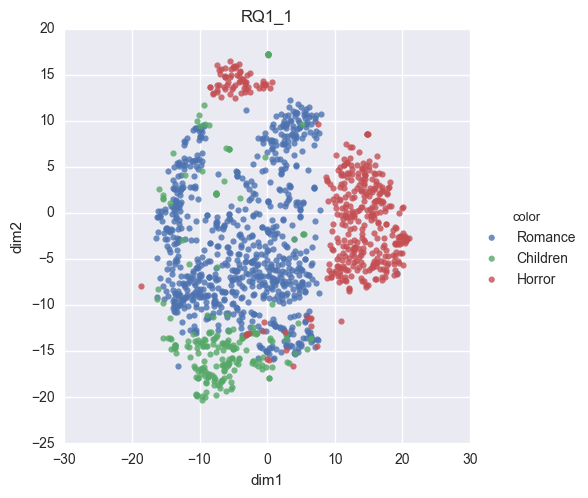

In [172]:
# Recomputing tsne for the selected samples
n_samples = 200
df_show1 = df_tsne[df_tsne.genre_1 == 'Romance'].sample(n=800)
df_show2 = df_tsne[df_tsne.genre_1 == 'Children'].sample(n=212)
df_show3 = df_tsne[df_tsne.genre_1 == 'Horror'].sample(n=400)
df_show = pd.concat([df_show1, df_show2, df_show3])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[int(movie_id)]
    vector = W_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_1']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('RQ1_1')
plt.show()

In [124]:
movieIds

array([   0,    0, 1496, ...,    0,    0, 7083], dtype=uint16)

# Plot one Genre vs Other

In [101]:
# Drama vs Comedy 

drama_genres = ['Drama', 'Action|Crime|Drama', 'Drama|War', 'Crime|Drama', 'Drama|Thriller', 'Adventure|Drama',
               'Crime|Drama|Mystery', 'Drama|Mystery', 'Action|Drama|War', 'Drama|Thriller|War']
comedy_genres = ['Adventure|Comedy', 'Comedy|Romance', 'Comedy', 'Children|Comedy', 'Action|Comedy', 'Animation|Comedy',
                'Action|Comedy|IMAX']


df_tsne['genre_2'] = 'Null'
df_tsne.loc[df_tsne.genres.isin(drama_genres), 'genre_2'] = 'Drama'
df_tsne.loc[df_tsne.genres.isin(comedy_genres), 'genre_2'] = 'Comedy'





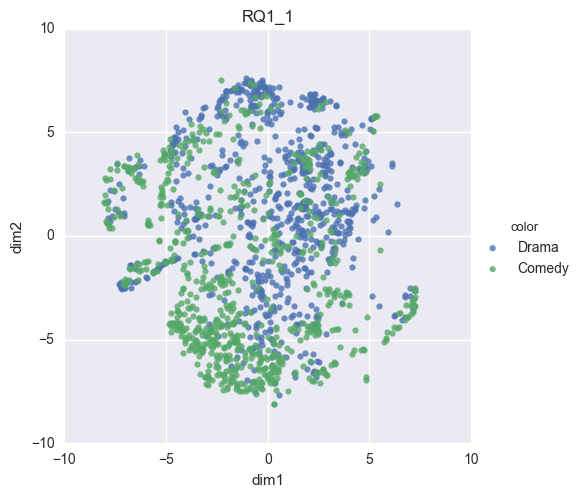

In [102]:
# Using the tsne with all the data
n_samples = 800
df_show1 = df_tsne[df_tsne.genre_2 == 'Drama'].sample(n=n_samples)
df_show2 = df_tsne[df_tsne.genre_2 == 'Comedy'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('RQ1_1')
plt.show()

(2000, 64)


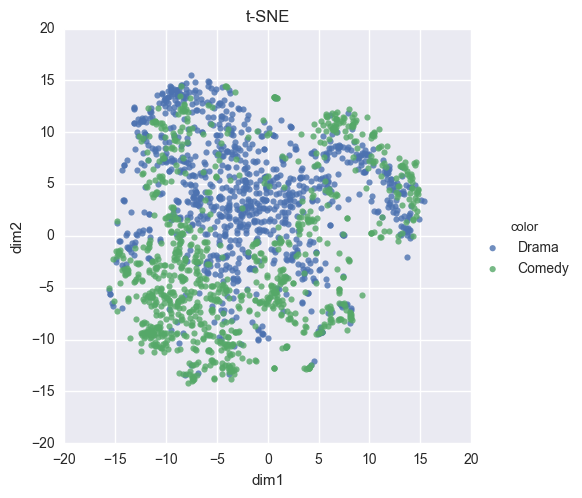

In [130]:
# Recomputing tsne for the selected samples
n_samples = 1000
df_show1 = df_tsne[df_tsne.genre_2 == 'Drama'].sample(n=n_samples)
df_show2 = df_tsne[df_tsne.genre_2 == 'Comedy'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[int(movie_id)]
    vector = W_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('RQ1_1')
plt.show()

# Plots more concrete genres

In [103]:
drama_war_action_genres = ['Drama|War', 'Action|Drama|War']
#comedy_romance_genres = ['Comedy|Drama|Romance']
comedy_romance_genres = ['Comedy|Romance' ]
children_comedy = ['Children|Comedy', 'Children|Comedy|Fantasy']
scifi_genres = ['Action|Sci-Fi', 'Action|Drama|Sci-Fi', 'Action|Sci-Fi|Thriller']


df_tsne['genre_3'] = 'Null'
df_tsne.loc[df_tsne.genres.isin(drama_war_action_genres), 'genre_3'] = 'Drama|War|Action'
df_tsne.loc[df_tsne.genres.isin(comedy_romance_genres), 'genre_3'] = 'Comedy|Romance'
df_tsne.loc[df_tsne.genres.isin(children_comedy), 'genre_3'] = 'Children|Comedy'
df_tsne.loc[df_tsne.genres.isin(scifi_genres), 'genre_3'] = 'Sci-Fi|Action'



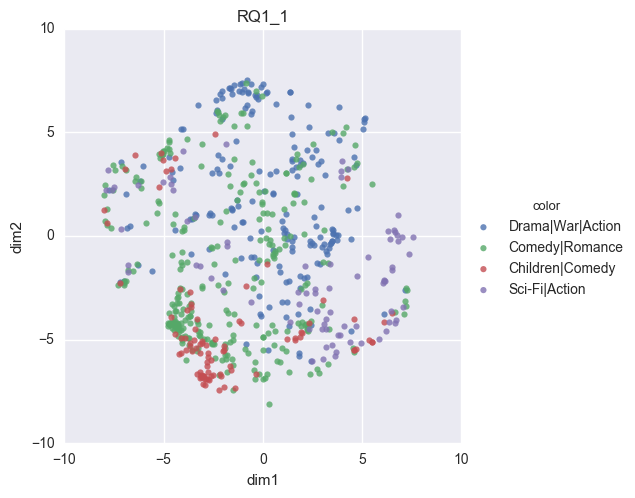

In [104]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.genre_3 == 'Drama|War|Action'].sample(n=192)
df_show2 = df_tsne[df_tsne.genre_3 == 'Comedy|Romance'].sample(n=292)
df_show3 = df_tsne[df_tsne.genre_3 == 'Children|Comedy'].sample(n=94)
df_show4 = df_tsne[df_tsne.genre_3 == 'Sci-Fi|Action'].sample(n=80)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show4])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_3']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('RQ1_1')
plt.show()

(658, 64)


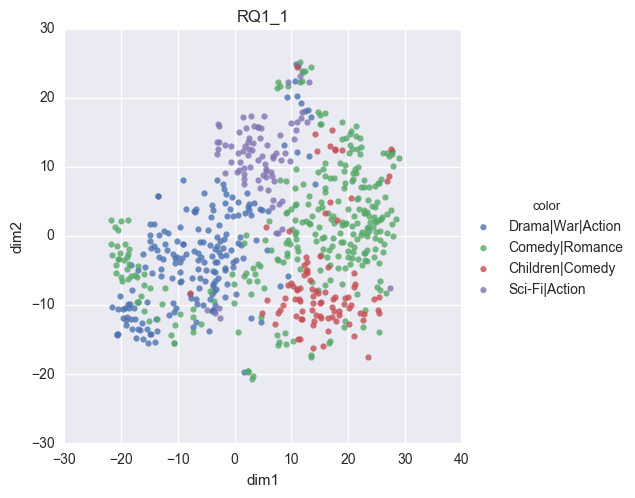

In [175]:
# Recomputing tsne for the selected samples
n_samples = 40
df_show1 = df_tsne[df_tsne.genre_3 == 'Drama|War|Action'].sample(n=192)
df_show2 = df_tsne[df_tsne.genre_3 == 'Comedy|Romance'].sample(n=292)
df_show3 = df_tsne[df_tsne.genre_3 == 'Children|Comedy'].sample(n=94)
df_show4 = df_tsne[df_tsne.genre_3 == 'Sci-Fi|Action'].sample(n=80)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show4])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[int(movie_id)]
    vector = W_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_3']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('RQ1_1')
plt.show()

# Plots for specific Movies

In [105]:
df_tsne['movie_id'] = df_tsne['movie_id'].astype(str) 

In [124]:
# Some sagas

star_wars_movies = [260, 1196, 1210, 2628, 5378, 33493]
#lord_of_the_rings_movies = [4993, 5952, 7153, 106489, 98809, 118696]
lord_of_the_rings_movies = [4993, 5952, 7153]
saw_movies = [8957, 39446, 48877, 55577, 63436, 72129, 81535]
#toy_story_movies = [78499, 3114, 1]
rocky_movies = [1954, 2409, 2410, 2411, 2412, 89045]
harry_potter_movies = [81834, 88125, 8368, 4896, 54001, 69844, 40815, 5816]
scream_movies = [86295, 1407, 1717, 3273]
star_wars_movies = [str(i) for i in star_wars_movies]
lord_of_the_rings_movies = [str(i) for i in lord_of_the_rings_movies]
saw_movies = [str(i) for i in saw_movies]
#toy_story_movies = [str(i) for i in toy_story_movies]
rocky_movies = [str(i) for i in rocky_movies]
harry_potter_movies = [str(i) for i in harry_potter_movies]
scream_movies = [str(i) for i in scream_movies]



df_tsne['saga'] = 'Null'
df_tsne.loc[df_tsne.movie_id.isin(star_wars_movies), 'saga'] = 'Star Wars'
df_tsne.loc[df_tsne.movie_id.isin(lord_of_the_rings_movies), 'saga'] = 'Lord of the Rings'
df_tsne.loc[df_tsne.movie_id.isin(saw_movies), 'saga'] = 'Saw'
#df_tsne.loc[df_tsne.movie_id.isin(toy_story_movies), 'saga'] = 'Toy Story'
df_tsne.loc[df_tsne.movie_id.isin(rocky_movies), 'saga'] = 'Rocky'
df_tsne.loc[df_tsne.movie_id.isin(harry_potter_movies), 'saga'] = 'Harry Potter'
df_tsne.loc[df_tsne.movie_id.isin(scream_movies), 'saga'] = 'Scream'



len_star_wars = len(df_tsne[df_tsne.saga == 'Star Wars'])
len_lord_of_the_rings = len(df_tsne[df_tsne.saga == 'Lord of the Rings'])
len_saw = len(df_tsne[df_tsne.saga == 'Saw'])
#len_toy_story = len(df_tsne[df_tsne.saga == 'Toy Story'])
len_rocky = len(df_tsne[df_tsne.saga == 'Rocky'])
len_harrypotter = len(df_tsne[df_tsne.saga == 'Harry Potter'])
len_scream = len(df_tsne[df_tsne.saga == 'Scream'])
print(len_star_wars)
print(len_lord_of_the_rings)
print(len_saw)
#print(len_toy_story)
print(len_rocky)
print(len_harrypotter)
print(len_scream)

6
3
7
6
8
4


In [439]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.saga == 'Star Wars'].sample(n=len_star_wars)
df_show2 = df_tsne[df_tsne.saga == 'Lord of the Rings'].sample(n=len_lord_of_the_rings)
df_show3 = df_tsne[df_tsne.saga == 'Saw'].sample(n=len_saw)
#df_show4 = df_tsne[df_tsne.saga == 'Toy Story'].sample(n=len_toy_story)
df_show5 = df_tsne[df_tsne.saga == 'Rocky'].sample(n=len_rocky)
df_show6 = df_tsne[df_tsne.saga == 'Harry Potter'].sample(n=len_harrypotter)
#df_show7 = df_tsne[df_tsne.saga == 'Scream'].sample(n=len_scream)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show5, df_show6])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['saga']))
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False, size=4.60, aspect=1.035)
#ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', markers=["o", "^", "s", "x", "*"], fit_reg=False)
plt.title('t-SNE')
plt.show()



AttributeError: 'DataFrame' object has no attribute 'saga'

In [440]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.saga == 'Star Wars'].sample(n=len_star_wars)
df_show2 = df_tsne[df_tsne.saga == 'Lord of the Rings'].sample(n=len_lord_of_the_rings)
df_show3 = df_tsne[df_tsne.saga == 'Saw'].sample(n=len_saw)
#df_show4 = df_tsne[df_tsne.saga == 'Toy Story'].sample(n=len_toy_story)
df_show5 = df_tsne[df_tsne.saga == 'Rocky'].sample(n=len_rocky)
df_show6 = df_tsne[df_tsne.saga == 'Harry Potter'].sample(n=len_harrypotter)
#df_show7 = df_tsne[df_tsne.saga == 'Scream'].sample(n=len_scream)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show5, df_show6])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['saga']))
#ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', markers=["o", "^", "s", "x", "v"], fit_reg=False, size=4.60, aspect=1.035)
plt.title('RNN-Emb-Word2vec', fontsize=11)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'saga'

# Plot the movies with the highest number of co-ocurrences

# Plot closest and most distant movies, and number of co-ocurrences

In [579]:
num_samples = 55
windows_size = 10

In [580]:
def num_coocurrences(windows_size, primary_movie, other_movies):
    dict_coocurrences = {}
    for movie in other_movies:
        dict_coocurrences[movie] = 0
    for seq in movie_sequences:
        if primary_movie in seq:
            idx_movie = seq.index(primary_movie)
            start = max(0, idx_movie - windows_size)
            end = min(len(seq[0]), idx_movie + windows_size + 1)
            window_seq = seq[0][start:end]
            for movie in other_movies:
                if movie in window_seq:
                    dict_coocurrences[movie] += 1
    return dict_coocurrences
        

In [581]:
# Find specific movie
df_movies[df_movies['title'].str.contains("Lord of the Rings")]
# Find movie by genre
# df_movies[df_movies['genres'].str.contains("Musical")]

,movieId,title,genres,year
2032,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy,1978
4897,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,2001
5853,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,2002
7041,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,2003


In [582]:
id_movie = 4993
print('Movie: ' + str(df_movies[df_movies.movieId == id_movie]))
similars = model.similar_by_word(str(id_movie), topn=num_samples, restrict_vocab=None)
movies = []
genres = []
similarities = []
most_similar_ids = []
for sim in similars:
    #ids_sim.append(int(sim[0]))
    movie = df_movies[df_movies.movieId == int(sim[0])]
    most_similar_ids.append(movie.movieId.values[0])
    movies.append(movie.title.values[0])
    genres.append(movie.genres.values[0])
    similarities.append(float(sim[1]))
df_similars = pd.DataFrame()
df_similars['ids'] = most_similar_ids
df_similars['movies'] = movies
df_similars['genres'] = genres
df_similars['similarities'] = similarities
df_similars.head()

Movie:       movieId                                              title  \
4897     4993  Lord of the Rings: The Fellowship of the Ring,...   

                 genres  year  
4897  Adventure|Fantasy  2001  


,ids,movies,genres,similarities
0,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,0.886356
1,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,0.847458
2,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.803849
3,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,0.743677
4,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0.729118


In [583]:
# Get most distant
print('Movie: ' + str(df_movies[df_movies.movieId == id_movie]))
similars = model.similar_by_word(str(id_movie), topn=10057, restrict_vocab=None)
similars = similars[-num_samples:]
print(len(similars))
movies = []
genres = []
similarities = []
most_distanct_ids = []
for sim in similars:
    #ids_sim.append(int(sim[0]))
    movie = df_movies[df_movies.movieId == int(sim[0])]
    most_distanct_ids.append(movie.movieId.values[0])
    movies.append(movie.title.values[0])
    genres.append(movie.genres.values[0])
    similarities.append(float(sim[1]))
df_distanct = pd.DataFrame()
df_distanct['ids'] = most_distanct_ids
df_distanct['movies'] = movies
df_distanct['genres'] = genres
df_distanct['similarities'] = similarities
df_distanct.head()

Movie:       movieId                                              title  \
4897     4993  Lord of the Rings: The Fellowship of the Ring,...   

                 genres  year  
4897  Adventure|Fantasy  2001  
55


,ids,movies,genres,similarities
0,26838,"Snapper, The (1993)",Comedy|Drama,-0.082858
1,4242,Beautiful Creatures (2000),Comedy|Crime|Drama|Thriller,-0.082899
2,48638,Fellini's Casanova (Il Casanova di Federico Fe...,Drama|Romance,-0.083972
3,4354,Unlawful Entry (1992),Crime|Thriller,-0.084055
4,7321,Twisted (2004),Thriller,-0.084566


In [584]:
most_similar_ids = [str(i) for i in most_similar_ids]
most_distanct_ids = [str(i) for i in most_distanct_ids]
dict_coocurrences = num_coocurrences(windows_size, str(id_movie), most_similar_ids + most_distanct_ids)
df_tsne['top_similar_distant'] = 'Null'
df_tsne.loc[df_tsne.movie_id.isin(most_similar_ids), 'top_similar_distant'] = 'Top similar'
df_tsne.loc[df_tsne.movie_id.isin(most_distanct_ids), 'top_similar_distant'] = 'Top distant'
df_tsne.loc[df_tsne.movie_id == str(id_movie), 'top_similar_distant'] = 'Selected movie'

df_tsne['co-occurrences'] = 0
df_tsne['co-occurrences'] = df_tsne['movie_id'].map(dict_coocurrences)


print(len(df_tsne[df_tsne['top_similar_distant'] == 'Top similar']))
print(len(most_similar_ids))
print(len(df_tsne[df_tsne['top_similar_distant'] == 'Top distant']))
print(len(most_distanct_ids))

54
55
55
55


In [585]:
df_tsne[df_tsne['top_similar_distant'] == 'Top similar'].head()

,x,y,movie_id,title,genres,years,top_similar_distant,co-occurrences
36,-3.82428,0.726496,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999,Top similar,8.0
453,-4.60596,0.469457,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,2003,Top similar,26.0
462,-6.89017,0.552074,3578,Gladiator (2000),Action|Adventure|Drama,2000,Top similar,4.0
519,-3.47641,0.915744,1213,Goodfellas (1990),Crime|Drama,1990,Top similar,0.0
757,-2.72732,1.01625,5995,"Pianist, The (2002)",Drama|War,2002,Top similar,0.0


In [586]:
df_tsne[df_tsne['top_similar_distant'] == 'Top distant'].head()

,x,y,movie_id,title,genres,years,top_similar_distant,co-occurrences
33,-2.08132,1.83303,26257,Sweet Sweetback's Baadasssss Song (1971),Crime|Drama|Thriller,1971,Top distant,0.0
290,-0.653431,0.468193,27166,Venus Beauty Institute (Vénus beauté) (1999),Comedy|Drama|Romance,0,Top distant,0.0
293,1.12264,3.40197,47670,"Syrian Bride, The (2004)",Drama,2004,Top distant,0.0
415,1.39826,0.0898288,26838,"Snapper, The (1993)",Comedy|Drama,1993,Top distant,0.0
1377,3.39861,-0.617654,5122,Summer of '42 (1971),Drama,1971,Top distant,1.0


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:965: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:987: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:965: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a sing

204.5
0.0


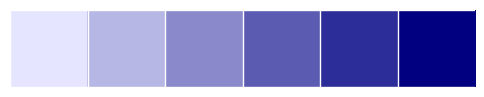

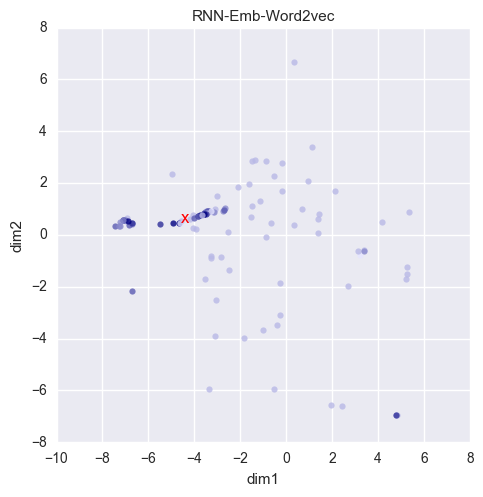

In [587]:
from sklearn import preprocessing

# Using the tsne with all the data
df_show1 = df_tsne[df_tsne.top_similar_distant == 'Top similar'].sample(n=num_samples-1)
df_show2 = df_tsne[df_tsne.top_similar_distant == 'Top distant'].sample(n=num_samples)
#df_show3 = df_tsne[df_tsne.top_similar_distant == 'Selected movie'].sample(n=1)
df_show = pd.concat([df_show1, df_show2])

X_scaled = preprocessing.robust_scale(df_show['co-occurrences'].values)
print(max(X_scaled))
print(min(X_scaled))
X_scaled = X_scaled + 15
X_scaled[-10] = 0
x_pos = df_tsne[df_tsne.top_similar_distant == 'Selected movie'].x
y_pos = df_tsne[df_tsne.top_similar_distant == 'Selected movie'].y
 
#df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['top_similar_distant']))
df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=X_scaled + 10))
#ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
#ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False, size=4.60, aspect=1.035)
cp = sns.light_palette("navy", reverse=False)
sns.palplot(cp)
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', palette=cp, fit_reg=False, legend=False)
#ax.fig.text(0.4, 0.7, "x", ha ='left', fontsize = 15)
ax.fig.axes[0].annotate('x', (x_pos, y_pos), fontsize=12, color='red')
plt.title('RNN-Emb-Word2vec', fontsize=11)
plt.show()

Second movie

In [588]:
df_date.movieId.value_counts()

58559     16738
318       15938
2571      15923
2959      15318
79132     14009
296       14002
356       13488
4993      13324
7153      12799
5952      12161
593       11831
2858      11177
858       11066
260       10986
4226      10872
527       10577
50        10345
60069     10191
1196      10034
1198       9943
72998      9737
4306       9723
7361       9688
4973       9672
480        9608
68157      9443
2762       9407
3578       9265
1          9260
68954      9257
          ...  
99058        21
68923        21
82022        21
70046        21
107117       21
4436         21
4692         21
37957        21
83601        21
3846         21
97692        21
2103         21
110387       21
103721       21
2977         21
97665        21
5227         21
5800         21
4164         21
48389        21
2098         21
5003         21
73879        21
71817        21
3648         21
74657        21
32022        21
52378        21
40494        21
57706        21
Name: movieId, dtype: in

In [591]:
num_samples = 55
windows_size = 10

In [592]:
# Find specific movie
df_movies[df_movies['title'].str.contains("Lord of the Rings")]
# Find movie by genre
# df_movies[df_movies['genres'].str.contains("Musical")]

,movieId,title,genres,year
2032,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy,1978
4897,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,2001
5853,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,2002
7041,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,2003


In [593]:
id_movie = 296
print('Movie: ' + str(df_movies[df_movies.movieId == id_movie]))
similars = model.similar_by_word(str(id_movie), topn=num_samples, restrict_vocab=None)
movies = []
genres = []
similarities = []
most_similar_ids = []
for sim in similars:
    #ids_sim.append(int(sim[0]))
    movie = df_movies[df_movies.movieId == int(sim[0])]
    most_similar_ids.append(movie.movieId.values[0])
    movies.append(movie.title.values[0])
    genres.append(movie.genres.values[0])
    similarities.append(float(sim[1]))
df_similars = pd.DataFrame()
df_similars['ids'] = most_similar_ids
df_similars['movies'] = movies
df_similars['genres'] = genres
df_similars['similarities'] = similarities
df_similars.head()

Movie:      movieId                title                       genres  year
293      296  Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller  1994


,ids,movies,genres,similarities
0,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,0.916845
1,2959,Fight Club (1999),Action|Crime|Drama|Thriller,0.915247
2,2858,American Beauty (1999),Comedy|Drama,0.885381
3,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.878139
4,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0.868732


In [594]:
# Get most distant
print('Movie: ' + str(df_movies[df_movies.movieId == id_movie]))
similars = model.similar_by_word(str(id_movie), topn=10057, restrict_vocab=None)
similars = similars[-num_samples:]
print(len(similars))
movies = []
genres = []
similarities = []
most_distanct_ids = []
for sim in similars:
    #ids_sim.append(int(sim[0]))
    movie = df_movies[df_movies.movieId == int(sim[0])]
    most_distanct_ids.append(movie.movieId.values[0])
    movies.append(movie.title.values[0])
    genres.append(movie.genres.values[0])
    similarities.append(float(sim[1]))
df_distanct = pd.DataFrame()
df_distanct['ids'] = most_distanct_ids
df_distanct['movies'] = movies
df_distanct['genres'] = genres
df_distanct['similarities'] = similarities
df_distanct.head()

Movie:      movieId                title                       genres  year
293      296  Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller  1994
55


,ids,movies,genres,similarities
0,6854,"Bedford Incident, The (1965)",Drama|Thriller|War,-0.011911
1,1401,Ghosts of Mississippi (1996),Drama,-0.012058
2,2069,"Trip to Bountiful, The (1985)",Drama,-0.012431
3,4798,Indiscreet (1958),Comedy|Romance,-0.012446
4,4740,Maybe Baby (2000),Comedy|Romance,-0.012866


In [595]:
most_similar_ids = [str(i) for i in most_similar_ids]
most_distanct_ids = [str(i) for i in most_distanct_ids]
dict_coocurrences = num_coocurrences(windows_size, str(id_movie), most_similar_ids + most_distanct_ids)
df_tsne['top_similar_distant'] = 'Null'
df_tsne.loc[df_tsne.movie_id.isin(most_similar_ids), 'top_similar_distant'] = 'Top similar'
df_tsne.loc[df_tsne.movie_id.isin(most_distanct_ids), 'top_similar_distant'] = 'Top distant'
df_tsne.loc[df_tsne.movie_id == str(id_movie), 'top_similar_distant'] = 'Selected movie'

df_tsne['co-occurrences'] = 0
df_tsne['co-occurrences'] = df_tsne['movie_id'].map(dict_coocurrences)

print(len(df_tsne[df_tsne['top_similar_distant'] == 'Top similar']))
print(len(most_similar_ids))
print(len(df_tsne[df_tsne['top_similar_distant'] == 'Top distant']))
print(len(most_distanct_ids))

54
55
55
55


In [596]:
df_tsne[df_tsne['top_similar_distant'] == 'Top similar'].head()

,x,y,movie_id,title,genres,years,top_similar_distant,co-occurrences
36,-3.82428,0.726496,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999,Top similar,2.0
181,-3.70776,0.68253,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,0,Top similar,42.0
270,-3.56926,0.81735,608,Fargo (1996),Comedy|Crime|Drama|Thriller,1996,Top similar,0.0
406,-3.36964,0.969163,1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller,1971,Top similar,1.0
453,-4.60596,0.469457,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,2003,Top similar,3.0


In [597]:
df_tsne[df_tsne['top_similar_distant'] == 'Top distant'].head()

,x,y,movie_id,title,genres,years,top_similar_distant,co-occurrences
163,-0.443811,-3.07301,48319,Flyboys (2006),Action|Adventure|Drama|War,2006,Top distant,0.0
194,5.21705,5.80781,32263,Vares: Private Eye (Vares - Yksityisetsivä) (2...,Action|Comedy|Crime|Thriller,0,Top distant,0.0
202,5.25848,5.75273,65243,Blackout (2008),Mystery|Thriller,2008,Top distant,0.0
334,-4.08519,-3.38773,46948,Monster House (2006),Animation|Children|Fantasy|Mystery,2006,Top distant,0.0
636,1.99603,-0.312497,2069,"Trip to Bountiful, The (1985)",Drama,1985,Top distant,0.0


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:965: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:987: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:965: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a sing

42.0
0.0


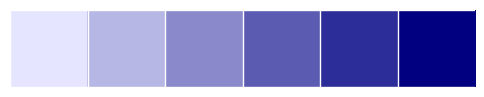

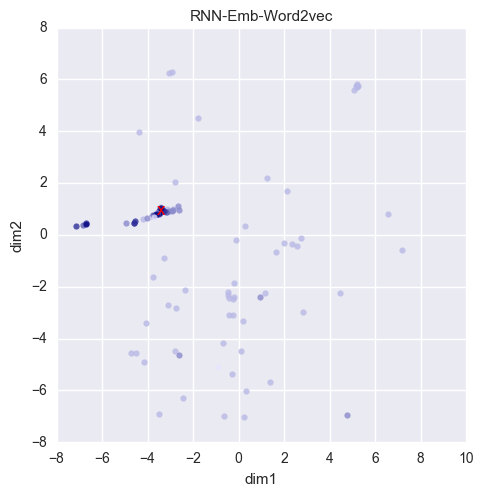

In [600]:
from sklearn import preprocessing

# Using the tsne with all the data
df_show1 = df_tsne[df_tsne.top_similar_distant == 'Top similar'].sample(n=num_samples-1)
df_show2 = df_tsne[df_tsne.top_similar_distant == 'Top distant'].sample(n=num_samples)
#df_show3 = df_tsne[df_tsne.top_similar_distant == 'Selected movie'].sample(n=1)
df_show = pd.concat([df_show1, df_show2])

X_scaled = preprocessing.robust_scale(df_show['co-occurrences'].values)
print(max(X_scaled))
print(min(X_scaled))
X_scaled = X_scaled + 15
X_scaled[-10] = 0
x_pos = df_tsne[df_tsne.top_similar_distant == 'Selected movie'].x
y_pos = df_tsne[df_tsne.top_similar_distant == 'Selected movie'].y
 
#df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['top_similar_distant']))
df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=X_scaled + 10))
#ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
#ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False, size=4.60, aspect=1.035)
cp = sns.light_palette("navy", reverse=False)
sns.palplot(cp)
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', palette=cp, fit_reg=False, legend=False)
#ax.fig.text(0.4, 0.7, "x", ha ='left', fontsize = 15)
ax.fig.axes[0].annotate('x', (x_pos, y_pos), fontsize=12, color='red')
plt.title('RNN-Emb-Word2vec', fontsize=11)
plt.show()

# OTHER THINGS

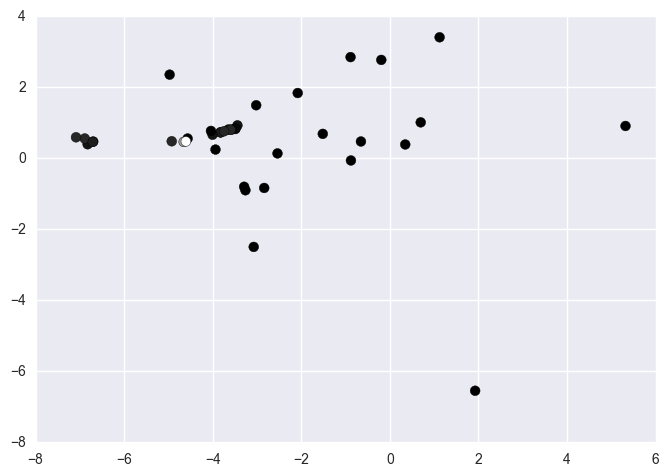

In [292]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data...
x = df_show['x'].values
y = df_show['y'].values
color = df_show['co-occurrences'].values

# Plot...
plt.scatter(x, y, c=color, s=50)
plt.gray()

plt.show()

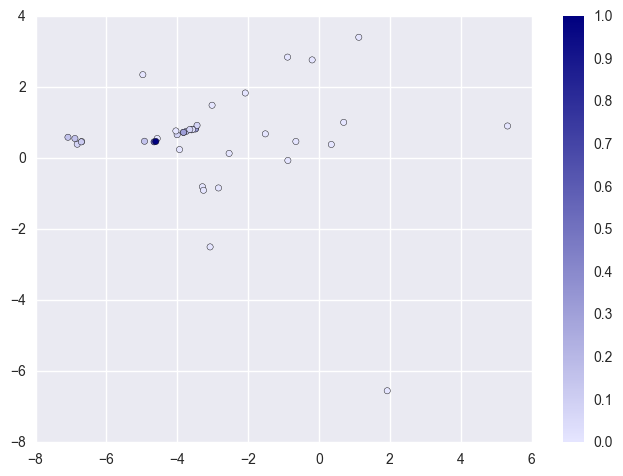

In [303]:
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

# construct cmap
my_cmap = sns.light_palette("Navy", as_cmap=True)

N = 500
x = df_show['x'].values
y = df_show['y'].values
colors = df_show['co-occurrences'].values / max(df_show['co-occurrences'].values)
plt.scatter(x, y, c=colors, cmap=my_cmap)
plt.colorbar()
plt.show()

In [ ]:
from sklearn import preprocessing

# Using the tsne with all the data
df_show1 = df_tsne[df_tsne.top_similar_distant == 'Top similar'].sample(n=num_samples-1)
df_show2 = df_tsne[df_tsne.top_similar_distant == 'Top distant'].sample(n=num_samples)
#df_show3 = df_tsne[df_tsne.top_similar_distant == 'Selected movie'].sample(n=1)
df_show = pd.concat([df_show1, df_show2])
df_show['co-ocurrence_category'] = 'Null

 
#df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['top_similar_distant']))
df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=X_scaled + 10))
#ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
#ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False, size=4.60, aspect=1.035)
cp = sns.light_palette("navy", reverse=False)
sns.palplot(cp)
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', palette=cp, fit_reg=False, legend=False)
ax.fig.text(0.4, 0.7, "X", ha ='left', fontsize = 15)
plt.title('RNN-Emb-Word2vec', fontsize=11)
plt.show()